# setup

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/code/')

In [4]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
train_frac = .8
DATA_DIR = Path.cwd().parent / 'data/train_frac_{}'.format(int(train_frac*100))
max_words = 5
max_len = 12000

In [5]:
DATA_DIR

PosixPath('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80')

In [6]:
train_values = pd.read_csv(DATA_DIR.parent / 'raw_data/train_values.csv', index_col='sequence_id')
train_labels = pd.read_csv(DATA_DIR.parent / 'raw_data/train_labels.csv', index_col='sequence_id')
# test_values = pd.read_csv(DATA_DIR.parent / 'raw_data/test_values.csv', index_col='sequence_id')

In [7]:
train_values, val_values, train_labels, val_labels = train_test_split(train_values, train_labels, 
                                              train_size = train_frac, random_state = 0, shuffle = True)

# processing

## look at sequence lengths

In [11]:
n_samples = train_values.shape[0]
sample_train_values = train_values.iloc[:n_samples,:]

NameError: ignored

In [12]:
del train_values

NameError: ignored

In [10]:
sequence_lengths = sample_train_values.sequence.apply(len)
sequence_lengths.describe([.5,.75,.9,.98])

count    50413.000000
mean      4840.905124
std       3881.028097
min         20.000000
50%       4744.000000
75%       7491.000000
90%       9442.800000
98%      13552.000000
max      60099.000000
Name: sequence, dtype: float64

## convert sequences

### keras

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [14]:
sample_train_values = pd.concat([sample_train_values, train_labels],axis=1)
label_columns = train_labels.columns
val_values = pd.concat([val_values, val_labels],axis=1)

In [15]:
len(set(sample_train_values.index))

50413

In [16]:
def split_long_sequences(df):
  # print(df)
  seq = df.iloc[0,0]
  seq_len = len(seq)
  splits = int(np.ceil((seq_len / max_len)))
  seq_list = []
  df = pd.concat([df] * splits, axis=0)
  for i in range(splits):
    if i == splits:
      df['sequence'][i] = seq
      # seq_list.append(seq)
    else:
      df['sequence'][i] = seq[:max_len]
      # seq_list.append(seq[:max_len])
      seq = seq[max_len:]

  df['weight'] = 1.0 / splits
  return df

sample_train_values = sample_train_values.groupby('sequence_id', group_keys=False).apply(split_long_sequences)

In [17]:
tok = Tokenizer(num_words=max_words, char_level=True)
tok.fit_on_texts(sample_train_values['sequence'])
sequences = tok.texts_to_sequences(sample_train_values['sequence'])
X = sequence.pad_sequences(sequences,maxlen=max_len, padding='post')
X.shape

(52228, 12000)

In [18]:
train_weights = sample_train_values['weight']
train_sequence_ids = sample_train_values.index
train_labels = sample_train_values[label_columns]

In [19]:
del sample_train_values

In [20]:
val_values = val_values.groupby('sequence_id', group_keys=False).apply(split_long_sequences)
sequences = tok.texts_to_sequences(val_values['sequence'])
X_val = sequence.pad_sequences(sequences,maxlen=max_len, padding='post')
X_val.shape

(13048, 12000)

In [21]:
val_values.shape

(13048, 1355)

In [22]:
val_weights = val_values['weight']
val_sequence_ids = val_values.index
val_labels = val_values[label_columns]

In [23]:
del val_values

In [150]:
test_values = test_values.groupby('sequence_id', group_keys=False).apply(split_long_sequences)
sequences = tok.texts_to_sequences(test_values['sequence'])
X_test = sequence.pad_sequences(sequences,maxlen=max_len, padding='post')
test_weights = test_values['weight']
test_sequence_ids = test_values.index

In [ ]:
del test_values

In [24]:
y = train_labels
y = np.array(y)
y.shape

(52228, 1314)

In [25]:
del train_labels

In [26]:
y_val = np.array(val_labels)
y_val.shape

(13048, 1314)

In [27]:
del val_labels

### custom

In [ ]:
nucleotide_dict = {'A': 1,
           'C': 2,
           'G': 3,
           'N': 4,
           'T': 5,
            0:  0}

In [ ]:
pad_list = [0] * max_len
def convert_sequence(sequence, max_len=max_len):
    
    seq_len = len(sequence)
    if seq_len > max_len:
        sequence = list(sequence)[:max_len]
    else:
        sequence = list(sequence) + pad_list[:(max_len - seq_len)]
        # sequence = list(sequence) * int((max_len / seq_len) + 1)
        # sequence = sequence[:max_len]
        
    sequence = list(map(nucleotide_dict.get, sequence)) #[nucleotide_dict[nuc] for nuc in sequence]
    return sequence

In [ ]:
sample_train_values = sample_train_values['sequence']
X = np.array([convert_sequence(seq) for seq in sample_train_values])
X.shape

(50413, 8000)

In [ ]:
del sample_train_values

In [ ]:
val_values = val_values['sequence']
X_val = np.array([convert_sequence(seq) for seq in val_values])
X_val.shape

(12604, 8000)

In [ ]:
del val_values

In [ ]:
X_test = np.array([convert_sequence(seq) for seq in test_values['sequence']])
X_test.shape

NameError: ignored

In [ ]:
del test_values

NameError: ignored

In [ ]:
y = train_labels.iloc[:n_samples,:]
y = np.array(y)
y.shape

(59866, 1314)

In [ ]:
del train_labels

In [ ]:
y_val = np.array(val_labels)
y_val.shape

(3151, 1314)

In [ ]:
del val_labels

## save and load

In [ ]:
np.save("{}/X_rnn".format(DATA_DIR), X)

In [ ]:
np.save("{}/X_val_rnn".format(DATA_DIR), X_val)

In [ ]:
np.save("{}/X_test_rnn".format(DATA_DIR), X_test)

In [ ]:
X = np.load("{}/X_rnn.npy".format(DATA_DIR))
X.shape

(50413, 12000)

In [ ]:
X_val = np.load("{}/X_val_rnn.npy".format(DATA_DIR))
X_val.shape

(12604, 12000)

In [ ]:
X_test = np.load("{}/X_test_rnn.npy".format(DATA_DIR))
X_test.shape

(18816, 12000)

In [ ]:
np.savetxt("{}/y.csv".format(DATA_DIR), y, delimiter=",")

In [ ]:
np.savetxt("{}/y_val.csv".format(DATA_DIR), y_val, delimiter=",")

In [92]:
!pip install datatable

     |████████████████████████████████| 83.7MB 36kB/s 


In [93]:
import datatable as dt
y = dt.fread(DATA_DIR / 'y.csv')#, max_nrows=30000)
y = y.to_numpy()
y_val = dt.fread(DATA_DIR / 'y_val.csv')#, max_nrows=3000)
y_val = y_val.to_numpy()

# cnn model

## libraries

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import clear_session
# from tensorflow.python.framework import ops
# from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.metrics import TopKCategoricalAccuracy
# from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
# from tensorflow.keras.utils import plot_model
# from keras.layers.merge import concatenate
# from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
import tensorflow as tf
# from tensorflow.keras import initializers
# from tensorflow.keras.activations import relu, sigmoid
from keras import Input, Model, Sequential
from keras.layers import Conv1D, Concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPool1D, GlobalAvgPool1D, MaxPool1D, AvgPool1D
from tensorflow.random import set_seed

In [29]:
top_10_accuracy = TopKCategoricalAccuracy(k=10)

In [29]:
@tf.function
def top10_accuracy_scorer(y_true, y_pred, from_logits=False):

    #avg for split predicitons
    if tf.shape(y_pred)[0] == len(val_weights):
      weights_tensor = tf.convert_to_tensor(val_weights_matrix)
      weights_tensor = tf.cast(weights_tensor, tf.float32)
      y_pred = tf.math.multiply(y_pred, weights_tensor)
      y_pred = y_pred.eval()#tf.make_ndarray(y_pred)
      y_pred = pd.DataFrame(y_pred, index=val_sequence_ids)
      y_pred = y_pred.groupby(y_pred.index).agg(np.mean)
      y_pred = y_pred.numpy()
      y_pred = tf.convert_to_tensor(y_pred)
      n_samples = np.sum(val_weights)

    

    values, indeces = tf.math.top_k(y_pred, 10)
    lab_indeces_tensor = tf.argmax(y_true,1)
    lab_indeces_tensor = tf.reshape(lab_indeces_tensor, 
                                    shape=(tf.shape(lab_indeces_tensor)[0],1))
    lab_indeces_tensor = tf.dtypes.cast(lab_indeces_tensor,dtype=tf.int32)
    equal_tensor = tf.equal(lab_indeces_tensor, indeces)
    equal_tensor = tf.cast(equal_tensor, tf.float32)

    if tf.shape(y_pred)[0] != len(val_weights):
      n_samples = tf.shape(lab_indeces_tensor)[0]

    
    sum_tensor = tf.reduce_sum(equal_tensor)
    top10_accuracy = sum_tensor/tf.cast(n_samples, tf.float32)
    
    return top10_accuracy

## single model

### setup

In [85]:
Trial summary
|-Trial ID: 3c095bfb11cee3603f804b048b9997c6
|-Score: 0.8945572972297668
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 64
|-dropout: False
|-dropout=True/rate: 0.03878795557405323
|-hidden_layer_size: 941
|-kernel_initializer: glorot_uniform
|-kernel_size_0: 40
|-kernel_size_1: 56
|-kernel_size_2: 40
|-num_filters_1: 224
|-tuner/bracket: 5
|-tuner/epochs: 13
|-tuner/initial_epoch: 7
|-tuner/round: 3
|-tuner/trial_id: cd5b6b3665964910633bc90504bb14e4

#split seq
Trial summary
|-Trial ID: 6e1562b140b2c8c32c75f4e68b59bc50
|-Score: 0.8945428729057312
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 96
|-dropout: True
|-dropout=True/rate: 0.2731039403132316
|-hidden_layer_size: 1390
|-kernel_initializer: glorot_uniform
|-kernel_size_0: 50
|-kernel_size_1: 40
|-kernel_size_2: 18
|-num_filters_1: 192
|-tuner/bracket: 4
|-tuner/epochs: 50
|-tuner/initial_epoch: 25
|-tuner/round: 4
|-tuner/trial_id: 223fc56edbd82f5ebe53ce31a32a26a4

SyntaxError: ignored

In [49]:
clear_session()
set_seed(0)

num_filters_1 = 400
kernel_size= {}
kernel_size[0]= 16
kernel_size[1]= 32
kernel_size[2]= 64
# kernel_size[3]= 2
n_kernels = len(kernel_size)

input_shape=(max_len)

# create seperate model graph for parallel processing with different filter sizes
# apply 'same' padding so that ll produce o/p tensor of same size for concatination
# cancat all paralle output

inp = Input(shape=input_shape)
emb = Embedding(max_words, 5, input_length=max_len)(inp)
convs = []

# pooling_1 = hp.Choice('pooling_1',['max','local_max'])
activation_function_1 = 'sigmoid'
initializer = 'glorot_uniform'

for k_no in range(n_kernels):
    conv = Conv1D(num_filters_1,
                  (kernel_size[k_no]),
                  strides=int(kernel_size[k_no]/8),
                  activation=activation_function_1,
                  kernel_initializer=initializer)(emb)

    # if pooling_1 == 'max':
    pool = GlobalMaxPool1D()(conv)
    # elif pooling_1 == 'avg':
    # pool = GlobalAvgPool1D()(conv)
    # elif pooling_1 == 'local_max':
    #   with hp.conditional_scope('pooling_1', 'local_max'):

    #     pool_size = hp.Int('max_pool_size_{}'.format(k_no), 2, 32)
    #     pool = MaxPool1D((pool_size))(conv)

    #     conv = Conv1D(num_filters_1,  
    #               (kernel_size[k_no]), 
    #               activation=activation_function_1,
    #               kernel_initializer=initializer)(pool)

    #     pool = GlobalMaxPool1D()(conv)
    # elif pooling_1 == 'local_avg':
    #   with hp.conditional_scope('pooling_1', 'local_avg'):
    #     pool_size = hp.Int('avg_pool_size_{}'.format(k_no), 1, 32)
    #     pool = AvgPool1D(pool_size)(conv)


    convs.append(pool)

if n_kernels > 1:
    out = Concatenate()(convs)
else:
    out = convs[0]

conv_model = Model(inputs=inp, outputs=out)

# add created model grapg in sequential model

model = Sequential()
model.add(conv_model)        # add model just like layer

model.add(Flatten())


model.add(BatchNormalization())

rate = .2731039403132316
model.add(Dropout(rate))

hidden_layer_size = 1390
activation_function = 'sigmoid'

model.add(Dense(hidden_layer_size, activation = activation_function))

model.add(Dense(y.shape[1], activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=[top_10_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 1200)              225225    
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1200)              4800      
_________________________________________________________________
dropout (Dropout)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 1390)              1669390   
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              1827774   
Total params: 3,727,189
Trainable params: 3,724,789
Non-trainable params: 2,400
__________________________________________

### run

In [50]:
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=5)

model.fit(X, y,
          batch_size = 256,
          epochs=50, 
          verbose=1, 
          validation_data=(X_val, y_val, val_weights), 
          callbacks=[callback],
          sample_weight=train_weights) #0.9019

Epoch 1/50
205/205 [==============================] - 60s 292ms/step - loss: 4.5643 - top_k_categorical_accuracy: 0.4897 - val_loss: 5.9164 - val_top_k_categorical_accuracy: 0.2454
Epoch 2/50
205/205 [==============================] - 60s 291ms/step - loss: 3.0567 - top_k_categorical_accuracy: 0.6597 - val_loss: 4.0002 - val_top_k_categorical_accuracy: 0.5949
Epoch 3/50
205/205 [==============================] - 60s 291ms/step - loss: 2.3443 - top_k_categorical_accuracy: 0.7607 - val_loss: 2.5864 - val_top_k_categorical_accuracy: 0.7354
Epoch 4/50
205/205 [==============================] - 60s 291ms/step - loss: 1.9111 - top_k_categorical_accuracy: 0.8217 - val_loss: 2.2571 - val_top_k_categorical_accuracy: 0.7761
Epoch 5/50
205/205 [==============================] - 60s 291ms/step - loss: 1.5856 - top_k_categorical_accuracy: 0.8658 - val_loss: 2.0891 - val_top_k_categorical_accuracy: 0.8010
Epoch 6/50
205/205 [==============================] - 60s 291ms/step - loss: 1.3564 - top_k_cat

In [51]:
val_weights_matrix = np.repeat(
    np.reshape(np.array(val_weights), (len(val_weights), 1)), 
    y_val.shape[1], axis = 1)

y_val_probs = model.predict(X_val)
y_val_probs = np.multiply(y_val_probs, val_weights_matrix)

y_val_probs_df = pd.DataFrame(y_val_probs, index=val_sequence_ids)
y_val_probs_df = y_val_probs_df.groupby(y_val_probs_df.index).agg(np.sum)

# y_probs = y_val_probs_df/y_val_probs_df.sum(axis=1)[:,None]

top10_idx = np.argpartition(y_val_probs_df.to_numpy(), -10, axis=1)[:, -10:]

y_val_df = pd.DataFrame(y_val, index=val_sequence_ids)
y_val_df = y_val_df.groupby(y_val_df.index).agg(np.mean)

y_idx = np.argpartition(y_val_df.to_numpy(), -1, axis=1)[:, -1:]
top_10_acc = (top10_idx == y_idx).any(axis=1).mean()
top_10_acc #.904 12k

0.8413995556966043

In [62]:
y_df = pd.DataFrame(y, index=train_sequence_ids)
y_df = y_df.groupby(y_df.index).agg(np.mean)
y_df.shape

(50413, 1314)

### save outputs

In [36]:
#trying 0.914 95%
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_rnn_model'.format(DATA_DIR))
model.save('{}/models/{}_rnn_model'.format(DATA_DIR, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/latest_rnn_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/06-10-2020 16_24_59_rnn_model/assets


In [80]:
import tensorflow as tf
model = tf.keras.models.load_model('{}/models/latest_rnn_model'.format(DATA_DIR),
                                               compile=True)

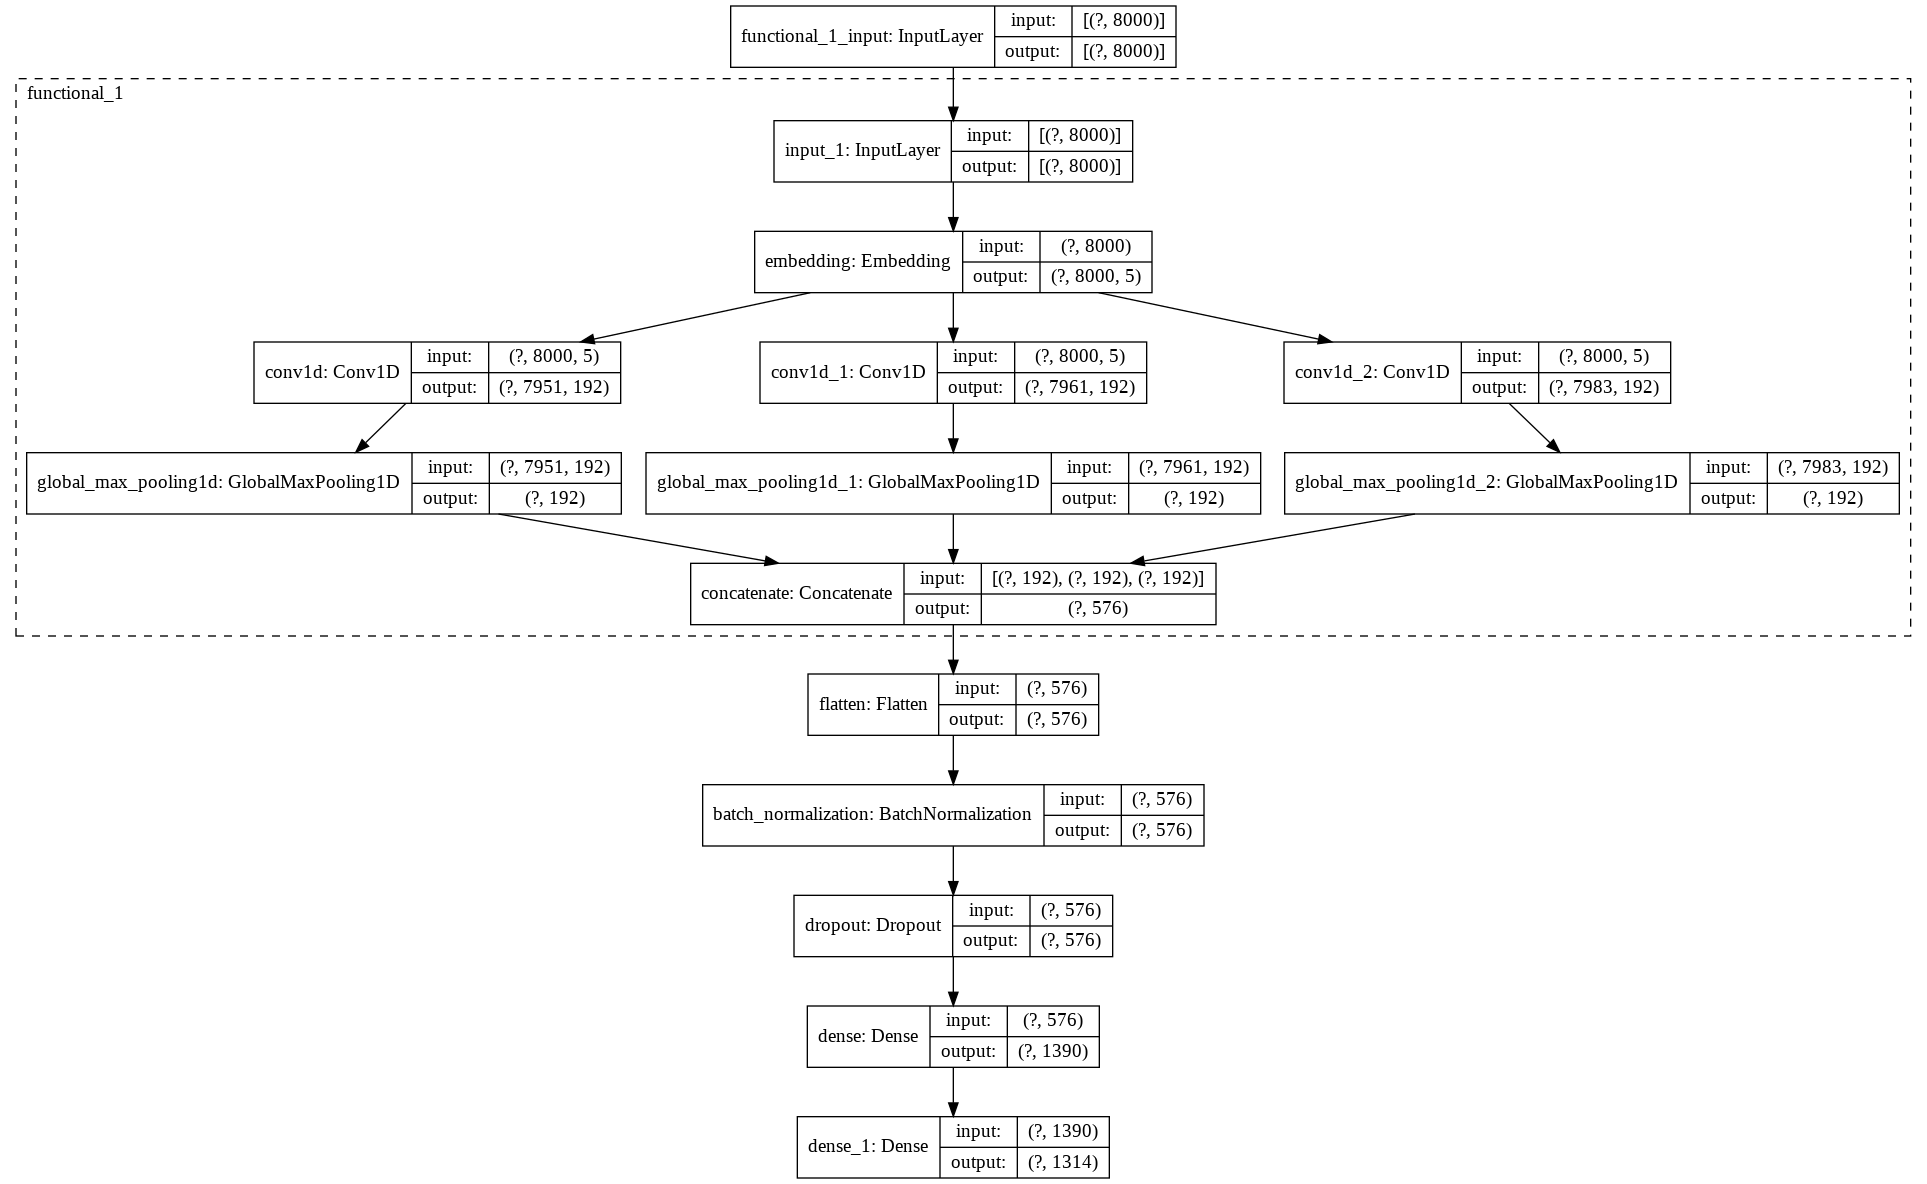

In [329]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=True)

In [81]:
y_probs = model.predict_proba(X)
y_val_probs = model.predict_proba(X_val)

In [82]:
def group_seq(y_probs, weights, sequence_ids):
  weights_matrix = np.repeat(
    np.reshape(np.array(weights), (len(weights), 1)), 
    y_probs.shape[1], axis = 1)
  weights_matrix.shape

  y_probs = np.multiply(y_probs, weights_matrix)
  y_probs_df = pd.DataFrame(y_probs, index=sequence_ids)
  y_probs_df = y_probs_df.groupby(y_probs_df.index).agg(np.sum)
  return y_probs_df

y_df_2 = group_seq(y_probs, train_weights, train_sequence_ids)
y_val_df_2 = group_seq(y_val_probs, val_weights, val_sequence_ids)
print(y_df_2.shape)
print(y_val_df_2.shape)

(50413, 1314)
(12604, 1314)


In [83]:
correct_probs = np.multiply(y_df_2, y_df)

y_probs_df = pd.DataFrame({'probs': correct_probs.sum(axis=1), 
                           'class':np.argmax(y_df.to_numpy(), axis=1)})
y_grouped_df_2 = y_probs_df.groupby('class'). \
  agg(mean = ('probs','mean'),
      count = ('probs','count'))
y_grouped_df_2['amount'] = (1 - y_grouped_df_2['mean']) * y_grouped_df_2['count']
y_grouped_df_2.sort_values('amount', ascending=False)

,mean,count,amount
class,,,
666,0.821888,6654,1.185159e+03
615,0.977883,2108,4.662354e+01
1176,0.874450,369,4.632778e+01
1074,0.923436,507,3.881804e+01
463,0.694681,101,3.083717e+01
686,0.886600,244,2.766971e+01
1075,0.845176,108,1.672099e+01
909,0.915423,188,1.590047e+01
302,0.875865,116,1.439963e+01


In [84]:
y_grouped_df_both = pd.concat([y_grouped_df_1, y_grouped_df_2], axis=1, )
y_grouped_df_both.columns = ['mean_1',	'count_1',	'amount_1', 'mean_2',	'count_2',	'amount_2']
y_grouped_df_both.corr()

,mean_1,count_1,amount_1,mean_2,count_2,amount_2
mean_1,1.000000,-0.055440,-0.100453,0.459838,-0.055440,-0.091914
count_1,-0.055440,1.000000,0.888221,-0.053320,1.000000,0.886106
amount_1,-0.100453,0.888221,1.000000,-0.081032,0.888221,0.998340
mean_2,0.459838,-0.053320,-0.081032,1.000000,-0.053320,-0.099021
count_2,-0.055440,1.000000,0.888221,-0.053320,1.000000,0.886106
amount_2,-0.091914,0.886106,0.998340,-0.099021,0.886106,1.000000


In [86]:
y_grouped_df_both['diff'] = np.abs(y_grouped_df_both['mean_1'] - y_grouped_df_both['mean_2'])
y_grouped_df_both.sort_values('diff', ascending=False)

,mean_1,count_1,amount_1,mean_2,count_2,amount_2,diff
class,,,,,,,
14,0.315856,1,0.684144,0.988043,1,1.195693e-02,0.672187
256,0.961151,11,0.427341,0.299478,11,7.705745e+00,0.661673
1060,0.992490,6,0.045061,0.364379,6,3.813725e+00,0.628111
1191,0.998592,11,0.015490,0.536224,11,5.101537e+00,0.462368
1116,0.535188,11,5.112936,0.986991,11,1.430953e-01,0.451804
369,0.989565,10,0.104355,0.554531,10,4.454686e+00,0.435033
844,0.578906,15,6.316411,0.971297,15,4.305492e-01,0.392391
511,0.596840,4,1.612639,0.972945,4,1.082214e-01,0.376104
141,0.985773,6,0.085365,0.625901,6,2.244591e+00,0.359871


In [39]:
np.savetxt("{}/y_probs_rnn.csv".format(DATA_DIR), y_df, delimiter=",")
np.savetxt("{}/y_val_probs_rnn.csv".format(DATA_DIR), y_val_df, delimiter=",")

### run test set

In [ ]:
model = tf.keras.models.load_model('{}/models/latest_rnn_model'.format(DATA_DIR),
                                               compile=True)

In [334]:
# X_test = np.load("{}/X_test_rnn.npy".format(DATA_DIR))
print(X_test.shape)
y_test_probs = model.predict_proba(X_test)

(22801, 8000)


In [335]:
y_test_df = group_seq(y_test_probs, test_weights, test_sequence_ids)
print(y_test_df.shape)

(18816, 1314)


In [336]:
np.savetxt("{}/y_test_probs_rnn.csv".format(DATA_DIR), y_test_probs_df.to_numpy(), delimiter=",")

## setup tune

In [28]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=82cb517e5f5e85ec4703e6c374ea1a921a3bfc7477eb4676089677e264d2f0a4
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=94f459e5061ca3fe9c2b9456a6a8fa16e565938e41acfdd2d2e9da502f1766fb
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [29]:
# variable initialization 
from keras import Input, Model, Sequential
from keras.layers import Conv1D, Concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPool1D, GlobalAvgPool1D, MaxPool1D, AvgPool1D
from tensorflow.random import set_seed

def build_model(hp):
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D, Flatten, Dropout
  from tensorflow.keras.optimizers import Adam, SGD, RMSprop
  from tensorflow.keras.backend import clear_session
  # from tensorflow.python.framework import ops
  # from imblearn.over_sampling import RandomOverSampler
  from tensorflow.keras.metrics import TopKCategoricalAccuracy
  # from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
  # from tensorflow.keras.utils import plot_model
  # from keras.layers.merge import concatenate
  # from tensorflow.keras import regularizers
  from tensorflow.keras.callbacks import EarlyStopping
  from tensorflow.random import set_seed
  import tensorflow as tf
  # from tensorflow.keras import initializers
  # from tensorflow.keras.activations import relu, sigmoid
  from keras import Input, Model, Sequential
  from keras.layers import Conv1D, Concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPool1D, GlobalAvgPool1D, MaxPool1D, AvgPool1D
  from tensorflow.random import set_seed

  clear_session()
  set_seed(0)

  num_filters_1 = hp.Int('num_filters_1', 32, 224, step=32)
  kernel_size= {}
  n_kernels = 3
  kernel_size_range = [2, 64]
  for i in range(n_kernels):
    kernel_size_i = hp.Int('kernel_size_{}'.format(i), kernel_size_range[0], kernel_size_range[1], step = 2)
    kernel_size[i] = kernel_size_i

  input_shape=(max_len)

  # create seperate model graph for parallel processing with different filter sizes
  # apply 'same' padding so that ll produce o/p tensor of same size for concatination
  # cancat all paralle output

  inp = Input(shape=input_shape)
  emb = Embedding(max_words, 5, input_length=max_len)(inp)
  convs = []

  # pooling_1 = hp.Choice('pooling_1',['max','local_max'])
  activation_function_1 = hp.Choice('activation_function', ['relu','tanh','sigmoid'])
  initializer = hp.Choice('kernel_initializer', 
  ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'ones', 'zeros'])

  for k_no in range(n_kernels):
      conv = Conv1D(num_filters_1,  
                    (kernel_size[k_no]), 
                    activation=activation_function_1,
                    kernel_initializer=initializer)(emb)

      # if pooling_1 == 'max':
      pool = GlobalMaxPool1D()(conv)
      # elif pooling_1 == 'avg':
      #   pool = GlobalAvgPool1D()(conv)
      # elif pooling_1 == 'local_max':
      #   with hp.conditional_scope('pooling_1', 'local_max'):

      #     pool_size = hp.Int('max_pool_size_{}'.format(k_no), 2, 32)
      #     pool = MaxPool1D((pool_size))(conv)

      #     conv = Conv1D(num_filters_1,  
      #               (kernel_size[k_no]), 
      #               activation=activation_function_1,
      #               kernel_initializer=initializer)(pool)

      #     pool = GlobalMaxPool1D()(conv)
      # elif pooling_1 == 'local_avg':
      #   with hp.conditional_scope('pooling_1', 'local_avg'):
      #     pool_size = hp.Int('avg_pool_size_{}'.format(k_no), 1, 32)
      #     pool = AvgPool1D(pool_size)(conv)


      convs.append(pool)

  if n_kernels > 1:
      out = Concatenate()(convs)
  else:
      out = convs[0]

  conv_model = Model(inputs=inp, outputs=out)

  # add created model grapg in sequential model

  model = Sequential()
  model.add(conv_model)        # add model just like layer
 
  model.add(Flatten())

  if hp.Boolean('batch_normalization'):
    model.add(BatchNormalization())

  if hp.Boolean('dropout'):
      with hp.conditional_scope('dropout', True):
        rate = hp.Float('rate',.001,.5,sampling='log')
        model.add(Dropout(rate))

  hidden_layer_size = hp.Int('hidden_layer_size', 50, 1500,sampling='log')
  activation_function = hp.Choice('activation_function', ['relu','tanh','sigmoid'])

  model.add(Dense(hidden_layer_size, activation = activation_function))

  model.add(Dense(y.shape[1], activation = 'softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=[top_10_accuracy])
  
  return model


## tune

In [ ]:
# import kerastuner as kt
from kerastuner import Objective
from kerastuner.tuners import Hyperband

class MyTuner(Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)

    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same argments as the BayesianOptimization Tuner.
tuner = MyTuner(
    build_model,
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_epochs=50,
    factor=2,
    hyperband_iterations=2,
    seed = 0,
    # distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tuning',
    project_name='cnn',
    overwrite=True)

callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=5)
clear_session()
tuner.search(X, y, 
             verbose=0,
             validation_data=(X_val, y_val, val_weights), 
            callbacks=[callback],
            sample_weight=train_weights) #max_len 16000

In [ ]:
#split seq
Trial summary
|-Trial ID: 6e1562b140b2c8c32c75f4e68b59bc50
|-Score: 0.8945428729057312
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 96
|-dropout: True
|-dropout=True/rate: 0.2731039403132316
|-hidden_layer_size: 1390
|-kernel_initializer: glorot_uniform
|-kernel_size_0: 50
|-kernel_size_1: 40
|-kernel_size_2: 18
|-num_filters_1: 192
|-tuner/bracket: 4
|-tuner/epochs: 50
|-tuner/initial_epoch: 25
|-tuner/round: 4
|-tuner/trial_id: 223fc56edbd82f5ebe53ce31a32a26a4


Trial complete
Trial summary
|-Trial ID: 3c095bfb11cee3603f804b048b9997c6
|-Score: 0.8945572972297668
|-Best step: 0
Hyperparameters:
|-activation_function: sigmoid
|-batch_normalization: True
|-batch_size: 64
|-dropout: False
|-dropout=True/rate: 0.03878795557405323
|-hidden_layer_size: 941
|-kernel_initializer: glorot_uniform
|-kernel_size_0: 40
|-kernel_size_1: 56
|-kernel_size_2: 40
|-num_filters_1: 224
|-tuner/bracket: 5
|-tuner/epochs: 13
|-tuner/initial_epoch: 7
|-tuner/round: 3
|-tuner/trial_id: cd5b6b3665964910633bc90504bb14e4

## other models

# rnn model

## libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Flatten, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
# from tensorflow.python.framework import ops
# from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.metrics import TopKCategoricalAccuracy
# from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
# from tensorflow.keras.utils import plot_model
# from keras.layers.merge import concatenate
# from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
# import tensorflow as tf
# from tensorflow.keras import initializers
# from tensorflow.keras.activations import relu, sigmoid

In [ ]:
top_10_accuracy = TopKCategoricalAccuracy(k=10)

## single model

### build model

In [ ]:
# X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
X.shape

(50413, 10000)

In [ ]:
clear_session()
set_seed(0)
model = Sequential()
# model.add(Dense(1500,input_shape=(X.shape[1],)))

model.add(Embedding(max_words, 5, input_length=max_len))

# model.add(LSTM(32, input_shape=(max_len,))) #return_sequences=True, stateful=True,
# model.add(Bidirectional(LSTM(32)))
# model.add(Flatten())
model.add(GRU(64))
# model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=[top_10_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10000, 5)          25        
_________________________________________________________________
gru (GRU)                    (None, 64)                13632     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              85410     
Total params: 103,227
Trainable params: 103,227
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)

model.fit(X, y,
          batch_size = 128,
          epochs=25, 
          verbose=1, 
          validation_data=(X_val, y_val), 
          callbacks=[callback])

Epoch 1/25
394/394 [==============================] - 188s 478ms/step - loss: 5.8316 - top_k_categorical_accuracy: 0.2952 - val_loss: 5.6744 - val_top_k_categorical_accuracy: 0.3008
Epoch 2/25
394/394 [==============================] - 190s 482ms/step - loss: 5.5091 - top_k_categorical_accuracy: 0.3244 - val_loss: 5.2918 - val_top_k_categorical_accuracy: 0.3653
Epoch 3/25
394/394 [==============================] - 189s 480ms/step - loss: 5.1688 - top_k_categorical_accuracy: 0.3742 - val_loss: 5.1022 - val_top_k_categorical_accuracy: 0.3833
Epoch 4/25
394/394 [==============================] - 189s 481ms/step - loss: 4.9511 - top_k_categorical_accuracy: 0.4056 - val_loss: 4.8716 - val_top_k_categorical_accuracy: 0.4269
Epoch 5/25
394/394 [==============================] - 189s 479ms/step - loss: 4.7146 - top_k_categorical_accuracy: 0.4417 - val_loss: 4.6661 - val_top_k_categorical_accuracy: 0.4647
Epoch 6/25
394/394 [==============================] - 188s 478ms/step - loss: 4.4632 - top

### save model and outputs

In [ ]:
#0.6519
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_rnn_model'.format(DATA_DIR))
model.save('{}/models/{}_rnn_model'.format(DATA_DIR, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/latest_cnn_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_95/models/18-09-2020 16_28_24_cnn_model/assets


In [ ]:
model = tf.keras.models.load_model('{}/models/latest_rnn_model'.format(DATA_DIR),
                                               compile=True)

In [ ]:
y_probs = model.predict_proba(X)
y_val_probs = model.predict_proba(X_val)


Instructions for updating:
Please use `model.predict()` instead.


In [ ]:
np.savetxt("{}/y_probs_rnn.csv".format(DATA_DIR), y_probs, delimiter=",")
np.savetxt("{}/y_val_probs_rnn.csv".format(DATA_DIR), y_val_probs, delimiter=",")


In [ ]:
X_test = np.load("{}/X_test_rnn.npy".format(DATA_DIR))
print(X_test.shape)
y_test_probs = model.predict_proba(X_test)
np.savetxt("{}/y_test_probs_rnn.csv".format(DATA_DIR), y_test_probs, delimiter=",")

(18816, 7000, 1, 5)
Instructions for updating:
Please use `model.predict()` instead.


## tune

In [ ]:
def build_model(hp):
  
  set_seed(0)
  model = Sequential()
  
  # if hp.Boolean('embedding'):
  model.add(Embedding(max_words, 5, input_length=10000))
  # else:
  #   with hp.conditional_scope('embedding', False):
  #     lstm_size_1 = hp.Int('lstm_size_1', 16, 256, step=16)
  #     model.add(LSTM(lstm_size_1,input_shape=(X.shape[1],)))
  
  
  

  # model.add(LSTM(32)) #return_sequences=True, stateful=True,
  lstm_size_2 = hp.Int('lstm_size_2', 16, 256, step=16)
  model.add(Bidirectional(LSTM(lstm_size_2)))

  hidden_layer_size = hp.Int('hidden_layer_size', 30, 1000)
  activation_function_3 = hp.Choice('activation_function_3', ['relu','tanh','sigmoid'])

  model.add(Dense(hidden_layer_size, activation = activation_function_3))

  model.add(Dense(y.shape[1], activation = 'softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=[top_10_accuracy])
  
  return model

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=14332134e6a75d848804740c492b4014f3488ea845b6abc150c49ebb9c0f9e1a
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=d17c9422332ecaf3b572c14a6c96e4013dbf8bf9fbaf879bda474dd76d05f429
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# import kerastuner as kt
from kerastuner import Objective
from kerastuner.tuners import Hyperband

class MyTuner(Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)

    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same argments as the BayesianOptimization Tuner.
tuner = MyTuner(
    build_model,
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_epochs=25,
    factor=2,
    hyperband_iterations=2,
    seed = 0,
    # distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tuning',
    project_name='cnn',
    overwrite=True)

callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)

tuner.search(X, y,
             validation_data=(X_val, y_val),
             verbose=0,
             callbacks=[callback])

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


CancelledError: ignored